# VARS - Cordell Bank, Greater Farallones NMS records

**Resources**
- https://sanctuaries.noaa.gov/library/imast_gis.html
- https://nmssanctuaries.blob.core.windows.net/sanctuaries-prod/media/archive/visit/images/cb_map_big.jpg
- https://nmssanctuaries.blob.core.windows.net/sanctuaries-prod/media/archive/visit/images/gf_map_big.jpg

In [1]:
## Imports

import pandas as pd
import numpy as np

import re # for extracting logon info from text file

import jaydebeapi # for connecting to VARS db
import VARS # for connecting to VARS db

In [2]:
## Extract logon information from text file -- This uses a guest username and pw that will let you download data but not overwrite anything!

# Get list of each line in file
filename = 'VARS_logon_info.txt'
f = open(filename, 'r')
lines = f.readlines()
f.close()

# Function for extracting information from lines
def get_single_quoted_text(s):
    """ 
    Takes string s and returns any text in s that is between the first set of single quotes, removing whitespace. 
    
    Example:
    s = "What if there's more ' than one' sest of single' quotes?"
    get_single_quoted_text(s) --> 's more'
    
    """
    
    extracted_text = re.search('''(?<=')\s*[^']+?\s*(?=')''', s)
    return(extracted_text.group().strip())

# Assign logon info
dr = get_single_quoted_text(lines[2])
name = get_single_quoted_text(lines[3])
pw = get_single_quoted_text(lines[4])
un = get_single_quoted_text(lines[5])
url = get_single_quoted_text(lines[6])

In [6]:
## Build SQL query -- This query grabs select columns (see those listed under SELECT) from the annotations table for non-embargoed records from 1989 (see last two lines)

sql_cb = """
        SELECT index_recorded_timestamp,
               observation_uuid,
               concept,
               observation_group,
               observer,
               image_url,
               depth_meters,
               latitude,
               longitude,
               oxygen_ml_per_l,
               psi,
               salinity,
               temperature_celsius,
               video_uri,
               video_sequence_name,
               chief_scientist
        FROM annotations a
        WHERE latitude > 37.7
      AND latitude < 38.3
      AND longitude > -124
      AND longitude < -123
    """
# NOTE -- appears to be no records inside Cordell Bank

sql_cb_and_gf = """
    SELECT index_recorded_timestamp,
               observation_uuid,
               concept,
               observation_group,
               observer,
               image_url,
               depth_meters,
               latitude,
               longitude,
               oxygen_ml_per_l,
               psi,
               salinity,
               temperature_celsius,
               video_uri,
               video_sequence_name,
               chief_scientist
        FROM annotations a
        WHERE latitude > 37.5
      AND latitude < 39.0
      AND longitude > -124.2
      AND longitude < -122.7
    """

In [7]:
## Query the database

# Get connection
conn = VARS.get_db_conn(dr, url, un, pw, name)

# Submit query
data, col_names = VARS.get_data(conn, sql_cb_and_gf)

# Close connection
conn.close()

In [8]:
## Check data is there

# Set column names
data.columns = col_names

print(data.shape)
data.head()

(361, 16)


,index_recorded_timestamp,observation_uuid,concept,observation_group,observer,image_url,depth_meters,latitude,longitude,oxygen_ml_per_l,psi,salinity,temperature_celsius,video_uri,video_sequence_name,chief_scientist
0,2006-04-29 14:29:46,9BABBA91-34B5-47CB-ADE7-C1E524CEE437,sediment,ROV,linda,http://search.mbari.org/ARCHIVE/frameGrabs/Tib...,437.559998,37.526524,-123.002732,0.72,89.699997,34.154999,6.795,urn:tid:mbari.org:T0975-01,Tiburon 0975,Charlie Paull
1,2006-04-29 14:29:46,9BABBA91-34B5-47CB-ADE7-C1E524CEE437,sediment,ROV,linda,http://search.mbari.org/ARCHIVE/frameGrabs/Tib...,437.559998,37.526524,-123.002732,0.72,89.699997,34.154999,6.795,urn:tid:mbari.org:T0975-01,Tiburon 0975,Charlie Paull
2,2006-04-29 14:29:46,9BABBA91-34B5-47CB-ADE7-C1E524CEE437,sediment,ROV,linda,http://search.mbari.org/ARCHIVE/frameGrabs/Tib...,437.559998,37.526524,-123.002732,0.72,89.699997,34.154999,6.795,urn:tid:mbari.org:T0975-01,Tiburon 0975,Charlie Paull
3,2006-04-29 14:29:46,9BABBA91-34B5-47CB-ADE7-C1E524CEE437,sediment,ROV,linda,http://search.mbari.org/ARCHIVE/frameGrabs/Tib...,437.559998,37.526524,-123.002732,0.72,89.699997,34.154999,6.795,urn:tid:mbari.org:T0975-01,Tiburon 0975,Charlie Paull
4,2006-04-29 15:43:59,C2D825FF-C387-4978-A54C-51FDED299168,sediment,ROV,linda,http://search.mbari.org/ARCHIVE/frameGrabs/Tib...,398.750000,37.528258,-123.002098,0.51,353.799988,34.202000,6.099,urn:tid:mbari.org:T0975-02,Tiburon 0975,Charlie Paull


In [9]:
## Group data by lon, lat

grouped = data.groupby(['latitude', 'longitude'], as_index=False)['observation_uuid'].count()
grouped

,latitude,longitude,observation_uuid
0,37.526046,-123.002465,2
1,37.526052,-123.002484,1
2,37.526055,-123.002460,3
3,37.526058,-123.002449,1
4,37.526058,-123.002448,4
...,...,...,...
163,37.528243,-123.002092,1
164,37.528248,-123.002103,1
165,37.528251,-123.002121,1
166,37.528253,-123.002102,1


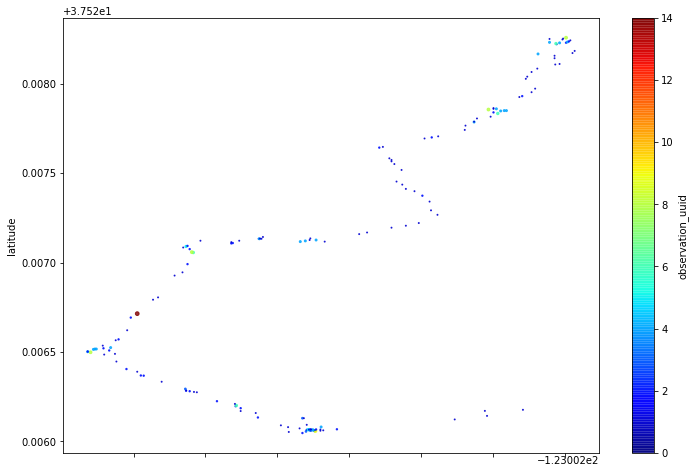

In [24]:
## Plot lat,lons

import matplotlib.pyplot as plt

grouped.plot(kind="scatter", x="longitude", y="latitude",
               s=grouped['observation_uuid'],
               c="observation_uuid", cmap=plt.get_cmap("jet"),
               colorbar=True, vmin=0, vmax=14, figsize=(12,8), alpha=0.8)

plt.savefig('GFNMS_transect_zoomed.png')

plt.show()

In [12]:
## Convert datframe to geodataframe

import geopandas as gpd

gdf = gpd.GeoDataFrame(
    grouped, geometry=gpd.points_from_xy(grouped.longitude, grouped.latitude))

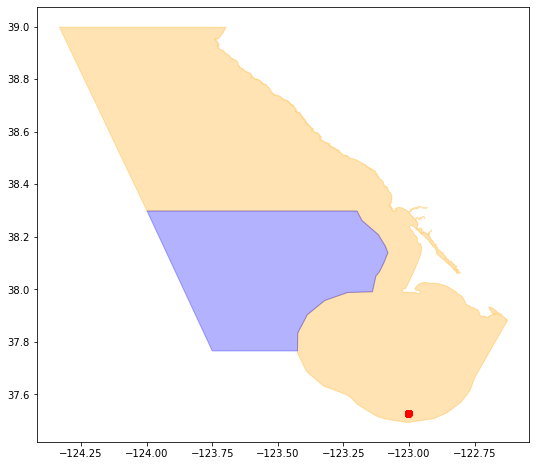

In [23]:
## Plot

boundary_gf = gpd.read_file('GFNMS_py.shp')
boundary_cb = gpd.read_file('CBNMS_py.shp')
ax = boundary_gf.plot(figsize=(12,8), edgecolor='orange', facecolor='orange', alpha=0.3)
boundary_cb.plot(ax=ax, edgecolor='blue', facecolor='blue', alpha=0.3)
gdf.plot(ax=ax, color='red')

plt.savefig('GFNMS_transect.png')

plt.show()